In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates ## Formatear las fechas en el eje x para mostrar solo horas, minutos y segundos
import os
from datetime import datetime, timedelta, time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

## Data

In [63]:
# Se crea un diccionario para almacenar los marcos de datos.
dataframes = {}

data_folder = os.path.join('..','Date_fabio') #creamos el path

#verificamos que el path sea correcto y en caso que asi sea, vemos los nombres de archivos dentro
if os.path.isdir(data_folder):
    files = os.listdir(data_folder) # guardamos la lista
    print(files)

# Se define una función para leer cada archivo y convertirlo en un dataframe
def read_file(filename):
    df = pd.read_excel(os.path.join(data_folder,filename))
    dataframes[filename] = df #Se crea un elemento del diccionario -> dataframa[CLAVE] = VALOR

#Leo todos los archivos excel
for filename in files:
    read_file(filename)

['Experimento  03-01-22-parafina.xlsx', 'Experimento 01-11-21.fix.xlsx', 'Experimento 03-11-21.xlsx', 'Experimento 07-12-21-parafina.xlsx', 'Experimento 09-11-21.xlsx', 'Experimento 11-11-21.xlsx', 'Experimento 12-11-21.xlsx', 'Experimento 18-11 - 21.xlsx', 'Experimento 22 - 12 - 21-vela.xlsx', 'Experimento 23 - 12 - 21-vela.xlsx', 'Experimento 24-11-21.xlsx', 'Experimento 29-10-21.XLS.xlsx']


In [64]:
# Lista para almacenar los DataFrames de Temperaturas
df_list = []
# Lista para almacenar los DataFrames de DateTime
df_date_list = []

for filename in files:
    # Selecciono las columnas 3 a 11, columnas de temperaturas. Lo guardo en un nuevo datafrema df.
    df = dataframes[filename].iloc[:, 2:10]
     # Agregar el DataFrame a la lista de DataFrame Temperaturas
    df_list.append(df)
    

In [65]:
#Acoto los datos a 100
num_datos = 99
for i, df in enumerate(df_list):
    df_list[i] = df[:num_datos]

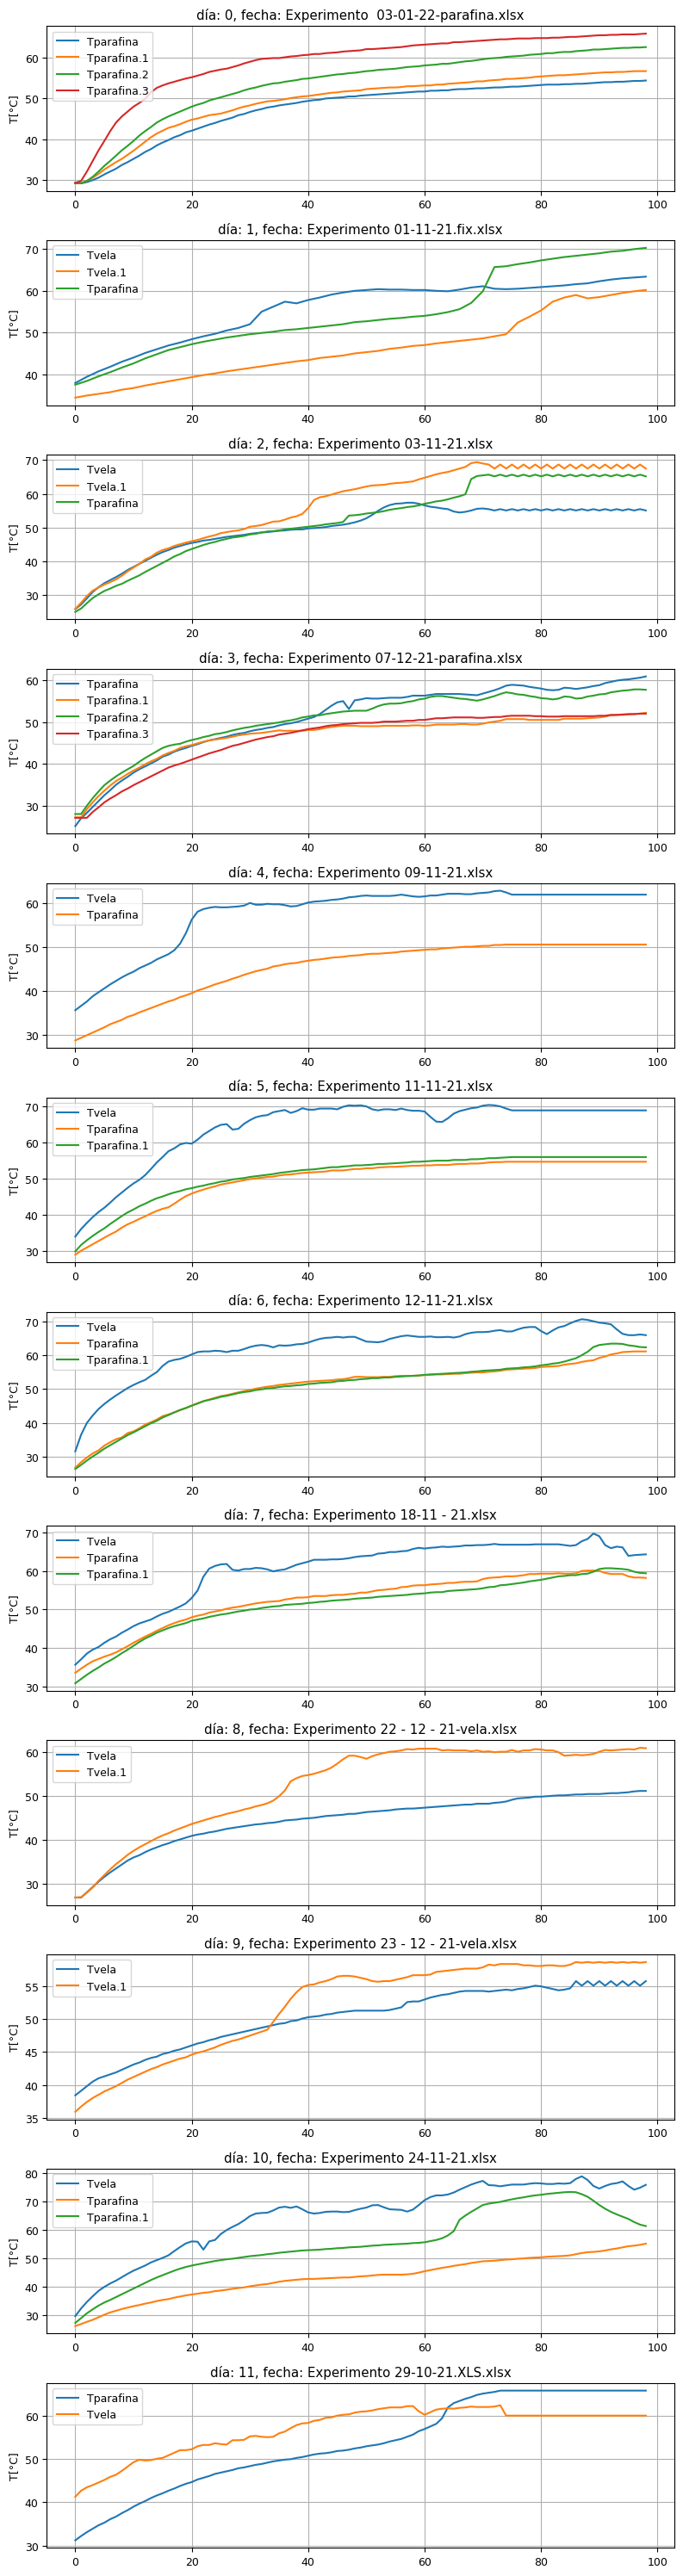

In [68]:
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 9}
plt.rc('font', **font)

fig, axs = plt.subplots(len(df_list),1, figsize=(8,30))
for i, df in enumerate(df_list): 
    axs[i].plot(df, '-', label = df.columns)
    axs[i].set_title(f"día: {i}, fecha: {files[i]}")
    axs[i].set_ylabel("T[°C]")
    axs[i].legend(loc = 'upper left')
    axs[i].grid()
fig.tight_layout()
plt.show()

Viendo la grafiaca, $\Delta t$ vale 60 seg. Es decir, se registra las variables cada una hora. Hay que corregir algunos dias, en los que los $\Delta t$ no son constantes.

## Autoencoder

El objetivo es usar un autoencoder para reducir la dimensionalidad de los datos de las series temporales y luego reconstruirlos, midiendo la pérdida (error) de reconstrucción para determinar cuántas magnitudes son necesarias para describir adecuadamente los datos.

In [71]:
#Modelo
class NN_deco(torch.nn.Module): 
    def __init__(self, n_in, latent_dim) -> None:
        super().__init__() 
        #contenedor encoder
        self. encoder = torch.nn.Sequential(
            torch.nn.Linear(in_features= n_in, out_features= 128), 
            torch.nn.ReLU(),
            #torch.nn.Dropout(0.25), #desactiva algunas neuronas?
            torch.nn.Linear(in_features= 128, out_features= 64),
            torch.nn.ReLU(),
            #torch.nn.Dropout(0.25),
            torch.nn.Linear(in_features= 64, out_features= 32),
            torch.nn.ReLU(),
            #torch.nn.Dropout(0.25),
            torch.nn.Linear(in_features= 32, out_features= latent_dim)
        )

        #contenedor decoder
        self. decoder = torch.nn.Sequential(
            torch.nn.Linear(in_features= latent_dim, out_features= 32),
            torch.nn.ReLU(),
            #torch.nn.Dropout(0.25),
            torch.nn.Linear(in_features= 32, out_features= 64),
            torch.nn.ReLU(),
            #torch.nn.Dropout(0.25),
            torch.nn.Linear(in_features= 64, out_features= 128),
            torch.nn.ReLU(),
            #torch.nn.Dropout(0.25),
            torch.nn.Linear(in_features= 128, out_features= n_in)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return decoded

### Aplico a todas las curvas T

Organizo las curvas de temperatura de a 300

In [72]:
data = []
for df in df_list:
    for col in df:
        data.append(df[col])
data = np.array(data)
data.shape

(34, 99)

In [73]:
#a todos los datos sacale las medias x' = (x-mu)/sigma
scaler = StandardScaler()
data = scaler.fit_transform(data)
data.shape

(34, 99)

In [79]:
# Hyperparametros
input_dim = num_datos #entradas
latent_dim = 3 #dimension del espacio latente. Cantidad de magnitudes o neuronas
num_epochs = 500 #Epocas
batch_size = 32 #cantidad de series o grupos qe se van a procesar
lr = 0.001 #taza de aprendizaje
dropout_act = False

# convertimos los datos a tensores
tensor_data= torch.tensor(data, dtype=torch.float32)
dataset = TensorDataset(tensor_data, tensor_data)  #El "objetivo" o "salida objetivo" es el mismo que el de entrada.
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Inicializo el modelo, función de perdida y el optimizador
model = NN_deco(input_dim, latent_dim)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [80]:
#Entrenamiento
history = []
model.train()
for epoch in range(num_epochs):
    for inputs, targets in dataloader: #target: "objetivos o "salida objetivo"
    
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    history.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/500], Loss: 0.1645
Epoch [20/500], Loss: 0.2383
Epoch [30/500], Loss: 0.0587
Epoch [40/500], Loss: 0.4791
Epoch [50/500], Loss: 0.0995
Epoch [60/500], Loss: 0.0328
Epoch [70/500], Loss: 0.0998
Epoch [80/500], Loss: 0.2304
Epoch [90/500], Loss: 0.2307
Epoch [100/500], Loss: 0.0811
Epoch [110/500], Loss: 0.1442
Epoch [120/500], Loss: 0.0650
Epoch [130/500], Loss: 0.1139
Epoch [140/500], Loss: 0.1656
Epoch [150/500], Loss: 0.0361
Epoch [160/500], Loss: 0.1239
Epoch [170/500], Loss: 0.1171
Epoch [180/500], Loss: 0.0358
Epoch [190/500], Loss: 0.0631
Epoch [200/500], Loss: 0.0438
Epoch [210/500], Loss: 0.0390
Epoch [220/500], Loss: 0.0244
Epoch [230/500], Loss: 0.1497
Epoch [240/500], Loss: 0.0769
Epoch [250/500], Loss: 0.2732
Epoch [260/500], Loss: 0.0778
Epoch [270/500], Loss: 0.0903
Epoch [280/500], Loss: 0.0138
Epoch [290/500], Loss: 0.0700
Epoch [300/500], Loss: 0.0414
Epoch [310/500], Loss: 0.0274
Epoch [320/500], Loss: 0.0296
Epoch [330/500], Loss: 0.0522
Epoch [340/500], Lo

In [76]:
# Crear el directorio para guardar las imágenes si no existe
path_img = os.path.join("..","img","Datos","Autoencoder")
os.makedirs(path_img, exist_ok=True)

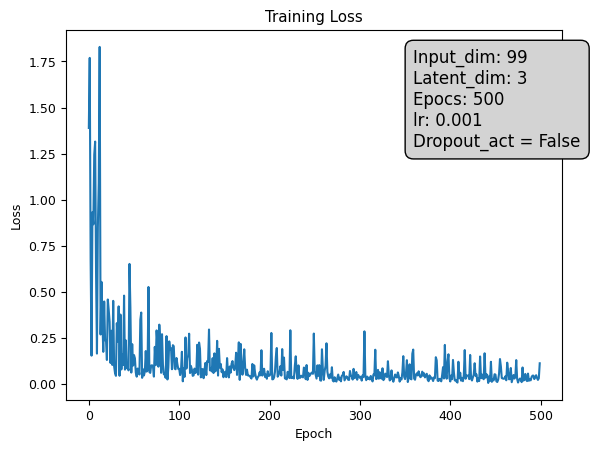

In [81]:
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
info_text = (
    f'Input_dim: {input_dim}\n'
    f'Latent_dim: {latent_dim}\n'
    f'Epocs: {num_epochs}\n'
    f'lr: {lr}\n'
    f'Dropout_act = {dropout_act}'
    )
plt.text(0.70, 0.95, info_text, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top',horizontalalignment='left',
         bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightgray'))

plt.savefig(os.path.join(path_img,"img4.png"), bbox_inches='tight')  # Guardar el gráfico en formato PNG
#plt.close()  # Cerrar la figura actual para liberar memoria
#plt.show()